 # Predicting Air Pressure System (APS) failures in Scania trucks using a TPOT AutoML pipeline
 ## Imports

In [1]:
import numpy as np
import pandas as pd
from preprocessing import preprocess_data, balance_data


 ## Read data

In [2]:
X_train = pd.read_csv('input/aps_failure_training_set.csv',na_values='na')
X_test = pd.read_csv('input/aps_failure_test_set.csv',na_values='na')


 ## Preprocessing
 deal with missing values and constant features and normalize

In [3]:
X_train, X_test, y_train, y_test = preprocess_data(X_train, X_test)
print(f'Data loaded: {len(X_train)} training observations, {len(X_test)} testing observations')

n_samples = 2500
X_train, y_train = balance_data(X_train, y_train, n_samples = n_samples)
print(f'Balanced training data ({n_samples/1000}/1): {len(X_train)} training observations, {len(X_test)} testing observations')


Data loaded: 60000 training observations, 16000 testing observations
Balanced training data (2.5/1): 3500 training observations, 16000 testing observations


 ## Scorer function
 A custom scorer function is created in order to reflect on the different cost of misclassification (fn > fp)

In [4]:
from sklearn.metrics import make_scorer
def scania_scorer(y_true,y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()  
    total_cost = 10*fp + 500*fn
    return total_cost

custom_scania_scorer = make_scorer(scania_scorer, greater_is_better=False)


 ## Model selection
 use best model as determined by TPOT AutoML

In [5]:
from xgboost import XGBClassifier
exported_pipeline = XGBClassifier(learning_rate=0.1, max_depth=8, min_child_weight=1, n_estimators=100, nthread=1, subsample=0.55)


In [6]:
### Alternative Pipeline, ranked 2nd ###

In [7]:
# from sklearn.pipeline import make_pipeline, make_union
# from tpot.builtins import StackingEstimator
# from tpot.export_utils import set_param_recursive
# from sklearn.neural_network import MLPClassifier
# from sklearn.naive_bayes import GaussianNB
# exported_pipeline = make_pipeline(
#     StackingEstimator(MLPClassifier(alpha = 0.001, learning_rate_init = 0.01, random_state=42)),
#     GaussianNB()
# )
# Fix random state for all the steps in exported pipeline
# set_param_recursive(exported_pipeline.steps, 'random_state', 42)


 ## Prediction
 Fit to training data and make prediction on testing data

In [8]:
exported_pipeline.fit(X_train, y_train)
results = exported_pipeline.predict(X_test)
probs = exported_pipeline.predict_proba(X_test)


 ## Evaluation
 The optimal probatbility threshold can be determined using a ROC curve
 <br>
 Code based on: https://www.kaggle.com/nicholasgah/obtain-optimal-probability-threshold-using-roc

In [9]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
print(f"Total cost before thresholding: {scania_scorer(y_test, results)}")
print(f"ROC AUC Score: {roc_auc_score(y_test, probs[:, -1])}")


Total cost before thresholding: 21080
ROC AUC Score: 0.9913944746666667


In [10]:
y_actual = pd.Series(y_test, name='Actual')
y_predict_tf = pd.Series(results, name='Predicted')
df_confusion = pd.crosstab(y_actual, y_predict_tf, rownames=['Actual'], colnames=['Predicted'], margins=True)
print (df_confusion)


Predicted      0    1    All
Actual                      
0          15267  358  15625
1             35  340    375
All        15302  698  16000


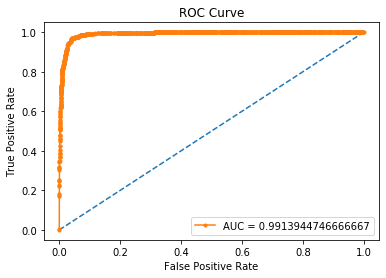

In [11]:
import matplotlib.pyplot as plt

false_pos_rate, true_pos_rate, proba = roc_curve(y_test, probs[:, -1])
plt.figure()
plt.plot([0,1], [0,1], linestyle="--") # plot random curve
plt.plot(false_pos_rate, true_pos_rate, marker=".", label=f"AUC = {roc_auc_score(y_test, probs[:, -1])}")
plt.title("ROC Curve")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.legend(loc="lower right")


In [12]:
optimal_proba_cutoff = sorted(list(zip(np.abs(true_pos_rate - false_pos_rate), proba)), key=lambda i: i[0], reverse=True)[0][1]
roc_predictions = [1 if i >= optimal_proba_cutoff else 0 for i in probs[:, -1]]
print(f"Optimal cut-off at: {optimal_proba_cutoff}")


Optimal cut-off at: 0.2077893316745758


In [13]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print(f"Total cost before and after thresholding: {scania_scorer(y_test, results)}, {scania_scorer(y_test, roc_predictions)}")


Total cost before and after thresholding: 21080, 11960


In [14]:
y_actual = pd.Series(y_test, name='Actual')
y_predict_tf = pd.Series(roc_predictions, name='Predicted')
df_confusion = pd.crosstab(y_actual, y_predict_tf, rownames=['Actual'], colnames=['Predicted'], margins=True)
print (df_confusion)


Predicted      0     1    All
Actual                       
0          14979   646  15625
1             11   364    375
All        14990  1010  16000


In [15]:
print(f'Total cost: {scania_scorer(y_test, roc_predictions)}')


Total cost: 11960


 ## Conclusion
 Using an XGBoost classifier and probability thresholding, the best total cost obtained is 11,960
 <br>
 Type 1 errors: 646 (Number of unnecessary checks)
 <br>
 Type 2 errors: 11 (Number of faulty trucks not recognized)